In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ismailpromus/skin-diseases-image-dataset

100% 5.18G/5.19G [02:30<00:00, 35.5MB/s]
100% 5.19G/5.19G [02:30<00:00, 37.0MB/s]


In [ ]:
!unzip "/content/skin-diseases-image-dataset.zip"

In [ ]:
#  article dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_regular
import seaborn as sns
from torchvision.utils import make_grid
import random
import os
import shutil
from PIL import Image

In [ ]:
batch_size = 32

In [ ]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [ ]:
!mkdir "train"
!mkdir "test"

In [ ]:
base = "/content/IMG_CLASSES/"
test = "/content/test/"
train = "/content/train/"

for folder in os.listdir(base):
  folder_path = base + folder

  os.mkdir(test + folder)
  os.mkdir(train + folder)

  for file_name in os.listdir(folder_path):
    file_path = folder_path + "/" + file_name

    r_num = random.randint(1, 5)

    if r_num != 1:
      shutil.move(file_path, train + folder + "/" + file_name)
    if r_num == 1:
      shutil.move(file_path, test + folder + "/" + file_name)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])


#  loading training data
train_data = Datasets.ImageFolder(root='/content/train',
                              transform=transform)

#  loading validation data
test_data = Datasets.ImageFolder(root='/content/test',
                                transform=transform)

In [ ]:
#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)

In [ ]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

#Define the image classes
classes = os.listdir("/content/IMG_CLASSES")

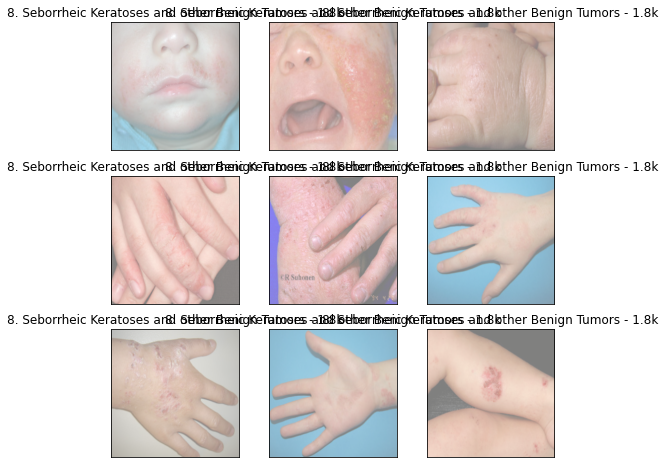

In [ ]:
#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        #Encoder
        self.conv1 = nn.Conv2d(3, 32, 6, padding=1)
        self.conv2 = nn.Conv2d(32, 16, 4, padding=1)
        self.conv3 = nn.Conv2d(16, 3, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(3, 16, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 32, 3, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(32, 3, 4, stride=2)

    def encode_forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        return x

    def decode_forward(self, x):
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.sigmoid(self.t_conv3(x))

        return x


    def forward(self, x):
        x = self.encode_forward(x)
        x = self.decode_forward(x)

        return x

In [ ]:
#Instantiate the model
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2))
)


In [ ]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (conv1): Conv2d(3, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2))
)

In [ ]:
#Epochs
n_epochs = 5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 18.707604
Epoch: 2 	Training Loss: 18.501181
Epoch: 3 	Training Loss: 18.506474
Epoch: 4 	Training Loss: 18.480131
Epoch: 5 	Training Loss: 18.436316


In [ ]:
#Batch of test images
dataiter = iter(test_loader)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 27, 27])
Original Images


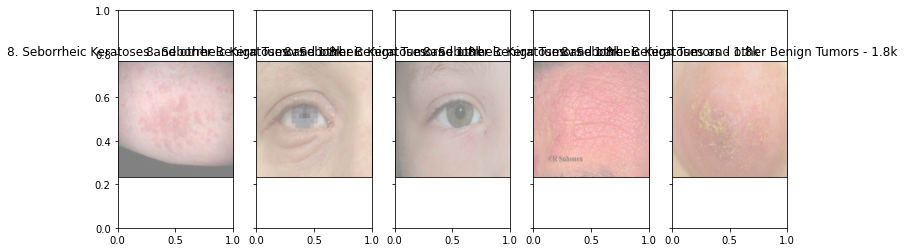

Reconstructed Images


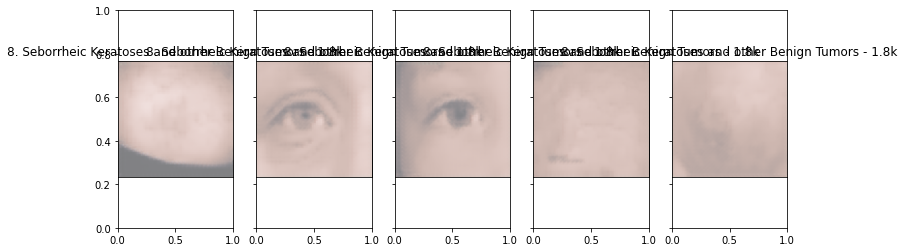

Bottleneck Images


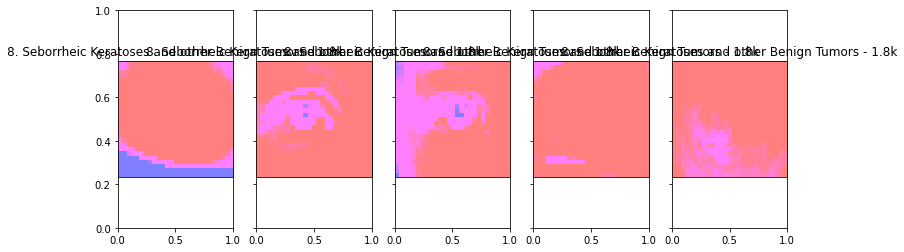

In [ ]:
images, labels = next(dataiter)

print(images.shape)

#Sample outputs and shape
output = model(images.cuda())
print(output.shape)

# Encoded Outputs (Outputs from Images only from the )
encoded_output = model.encode_forward(images.cuda())
print(encoded_output.shape)


images = images.numpy()

output = output.view(batch_size, 3, 224, 224)
output = output.detach().cpu().numpy()

encoded_output = encoded_output.view(batch_size, 3, 27, 27)
encoded_output = encoded_output.detach().cpu().numpy()


#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Bottleneck Images
print('Bottleneck Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(encoded_output[idx])
    ax.set_title(classes[labels[idx]])
plt.show()


In [ ]:
!mkdir "IMG_CLASSES_COMP"

In [ ]:
! kaggle datasets download ismailpromus/skin-diseases-image-dataset

skin-diseases-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!rmdir "/content/IMG_CLASSES/"
!unzip "/content/skin-diseases-image-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-65.jpg  
  inflating: IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-66.jpg  
  inflating: IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-67.jpg  
  inflating: IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-69.jpg  
  inflating: IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-7.jpg  
  inflating: IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-70.jpg  
  inflating: IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-71.jpg  
  inflating: IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin

In [ ]:
base = "/content/IMG_CLASSES/"
comp = "/content/IMG_CLASSES_COMP/"

for folder in os.listdir(base):
  folder_path = comp + folder
  os.mkdir(folder_path)

In [ ]:
transform_image = transforms.ToPILImage()

for folder in os.listdir(base):
  base_folder_path = base + folder
  comp_folder_path = comp + folder


  for file_name in os.listdir(base_folder_path):
    base_file_path = base_folder_path + "/" + file_name
    comp_file_path = comp_folder_path + "/" + file_name


    img = Image.open(base_file_path)

    img_tensor = transform(img)

    encoded_output = model.encode_forward(img_tensor.cuda())

    encoded_output = encoded_output.view(1, 3, 27, 27)
    encoded_output = encoded_output.detach().cpu()

    encoded_output = encoded_output[0]

    encoded_img = transform_image(encoded_output)

    encoded_img.save(comp_file_path)